<a href="https://colab.research.google.com/github/roksanakanicka/Matcha_Memory/blob/main/Hierarchical_Clustering_Tradeoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Weighted K-Means Clustering

Demographic segmentation using hierarchical clustering on features f0-f11.
Evaluates multiple parameter combinations and reports trade-offs between
segmentation granularity, cluster size, and within-cluster homogeneity.

Parameters evaluated:
- min_improvement: [0.04, 0.05, 0.06, 0.07]
- min_size: [50, 75, 100, 150]
- max_depth: 50
- force_split_threshold: 500k observations

Output: clustered_data.csv with cluster assignments using selected parameters

## IMPORTS

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import os
import gdown
from typing import List, Tuple, Dict
import warnings
import json
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## DATA LOADING

In [2]:
DATA_PATH = 'criteo-uplift-v2.1.csv.gz'
if not os.path.exists(DATA_PATH):
    gdown.download(
        "https://drive.google.com/uc?id=1KQOO_3R5CIiohPptTVFmk5kZ_nJ7KdEe",
        DATA_PATH,
        quiet=False
    )

df_full = pd.read_csv(DATA_PATH)
feature_cols = [f'f{i}' for i in range(12)]

Downloading...
From (original): https://drive.google.com/uc?id=1KQOO_3R5CIiohPptTVFmk5kZ_nJ7KdEe
From (redirected): https://drive.google.com/uc?id=1KQOO_3R5CIiohPptTVFmk5kZ_nJ7KdEe&confirm=t&uuid=6709d150-1b83-41b0-8fef-bb04491316e8
To: /content/criteo-uplift-v2.1.csv.gz
100%|██████████| 311M/311M [00:04<00:00, 65.0MB/s]


## HIERARCHICAL WEIGHTED K-MEANS CLASS

In [3]:
class HierarchicalWeightedKMeans:

    def __init__(self, min_improvement: float, min_size: int,
                 variance_threshold: float = 0.02, max_depth: int = 50,
                 force_split_threshold: int = 500000):
        self.min_improvement = min_improvement
        self.min_size = min_size
        self.variance_threshold = variance_threshold
        self.max_depth = max_depth
        self.force_split_threshold = force_split_threshold
        self.selected_features = None
        self.scaler = None

    def _select_features(self, X: pd.DataFrame) -> List[str]:
        variances = X.var(ddof=1)
        selected = variances[variances >= self.variance_threshold].index.tolist()
        return selected

    def _standardize_features(self, X: pd.DataFrame) -> np.ndarray:
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        return X_scaled

    def _distance_to_centroid(self, X: np.ndarray) -> float:
        centroid = np.mean(X, axis=0)
        distances = np.linalg.norm(X - centroid, axis=1)
        return np.mean(distances)

    def _try_split_with_threshold(self, X: np.ndarray, threshold: float) -> Tuple[bool, np.ndarray, float]:
        parent_distance = self._distance_to_centroid(X)

        kmeans = MiniBatchKMeans(
            n_clusters=2,
            batch_size=min(2048, len(X)),
            random_state=42,
            n_init=10,
            max_iter=100
        )
        child_labels = kmeans.fit_predict(X)

        unique, counts = np.unique(child_labels, return_counts=True)
        if np.any(counts < self.min_size):
            return False, None, 0.0

        child_distances = []
        child_sizes = []
        for label in unique:
            mask = child_labels == label
            X_child = X[mask]
            child_dist = self._distance_to_centroid(X_child)
            child_distances.append(child_dist)
            child_sizes.append(len(X_child))

        weighted_avg_child_distance = np.average(child_distances, weights=child_sizes)
        improvement = parent_distance - weighted_avg_child_distance
        should_split = improvement >= threshold

        return should_split, child_labels, improvement

    def _try_split(self, X: np.ndarray, indices: np.ndarray, depth: int) -> Tuple[bool, np.ndarray, float]:
        if len(X) < 2 * self.min_size or depth >= self.max_depth:
            return False, None, 0.0

        if len(X) > self.force_split_threshold:
            for attempt_threshold in [0.04, 0.03, 0.02, 0.01, 0.005, 0.001]:
                should_split, child_labels, improvement = self._try_split_with_threshold(X, attempt_threshold)
                if should_split:
                    return True, child_labels, improvement
            return False, None, 0.0
        else:
            return self._try_split_with_threshold(X, self.min_improvement)

    def fit_predict(self, X: pd.DataFrame) -> Tuple[np.ndarray, float]:
        self.selected_features = self._select_features(X[feature_cols])
        X_selected = X[self.selected_features]
        X_scaled = self._standardize_features(X_selected)

        n_samples = len(X_scaled)
        labels = np.zeros(n_samples, dtype=int)
        cluster_queue = [(np.arange(n_samples), 0, 0)]
        next_cluster_id = 1

        while cluster_queue:
            indices, cluster_id, depth = cluster_queue.pop(0)
            X_cluster = X_scaled[indices]

            should_split, child_labels, improvement = self._try_split(
                X_cluster, indices, depth
            )

            if should_split:
                for child_label in [0, 1]:
                    child_mask = child_labels == child_label
                    child_indices = indices[child_mask]
                    labels[child_indices] = next_cluster_id
                    cluster_queue.append((child_indices, next_cluster_id, depth + 1))
                    next_cluster_id += 1
            else:
                labels[indices] = cluster_id

        mean_dist = self._calculate_mean_distance(X_scaled, labels)
        return labels, mean_dist

    def _calculate_mean_distance(self, X_scaled: np.ndarray, labels: np.ndarray) -> float:
        total_dist = 0.0
        total_samples = len(X_scaled)

        for cluster_id in np.unique(labels):
            mask = labels == cluster_id
            X_cluster = X_scaled[mask]
            cluster_size = len(X_cluster)
            cluster_avg_dist = self._distance_to_centroid(X_cluster)
            total_dist += cluster_size * cluster_avg_dist

        mean_dist = total_dist / total_samples
        return mean_dist

## UTILITY FUNCTIONS

In [4]:
def stratified_sample(df: pd.DataFrame, frac: float, by: str, random_state: int = 42) -> pd.DataFrame:
    return df.groupby(by, group_keys=False).apply(
        lambda x: x.sample(frac=frac, random_state=random_state)
    ).reset_index(drop=True)


def calculate_cluster_stats(labels: np.ndarray) -> Dict:
    unique, counts = np.unique(labels, return_counts=True)
    return {
        'n_clusters': len(unique),
        'mean_size': np.mean(counts),
        'median_size': np.median(counts),
        'min_size': np.min(counts),
        'max_size': np.max(counts),
        'std_size': np.std(counts, ddof=1)
    }

## GRID SEARCH ON SAMPLE

In [5]:
print(f"Dataset: {df_full.shape[0]:,} observations, {len(feature_cols)} features")

df_sample = stratified_sample(df_full, frac=0.30, by='treatment')
print(f"Sample: {len(df_sample):,} observations")

min_improvement_values = [0.04, 0.05, 0.06, 0.07]
min_size_values = [50, 75, 100, 150]

results = []
total_configs = len(min_improvement_values) * len(min_size_values)

for i, min_imp in enumerate(min_improvement_values):
    for j, min_size in enumerate(min_size_values):
        config_num = i * len(min_size_values) + j + 1
        print(f"\nConfig {config_num}/{total_configs}: min_improvement={min_imp}, min_size={min_size}")

        clusterer = HierarchicalWeightedKMeans(
            min_improvement=min_imp,
            min_size=min_size,
            variance_threshold=0.02,
            max_depth=50,
            force_split_threshold=500000
        )

        labels, mean_dist = clusterer.fit_predict(df_sample)
        stats = calculate_cluster_stats(labels)

        max_cluster_pct = stats['max_size'] / len(df_sample) * 100

        results.append({
            'min_improvement': min_imp,
            'min_size': min_size,
            'mean_dist': mean_dist,
            'n_clusters': stats['n_clusters'],
            'median_size': stats['median_size'],
            'mean_size': stats['mean_size'],
            'min_cluster_size': stats['min_size'],
            'max_cluster_size': stats['max_size'],
            'max_cluster_pct': max_cluster_pct
        })

        print(f"  Result: mean_dist={mean_dist:.4f}, n_clusters={stats['n_clusters']}, median_size={stats['median_size']:.0f}, max_size={stats['max_size']:,} ({max_cluster_pct:.1f}%)")

results_df = pd.DataFrame(results)

Dataset: 13,979,592 observations, 12 features
Sample: 4,193,877 observations

Config 1/16: min_improvement=0.04, min_size=50
  Result: mean_dist=0.1924, n_clusters=6598, median_size=89, max_size=191,842 (4.6%)

Config 2/16: min_improvement=0.04, min_size=75
  Result: mean_dist=0.2002, n_clusters=4825, median_size=134, max_size=191,842 (4.6%)

Config 3/16: min_improvement=0.04, min_size=100
  Result: mean_dist=0.2063, n_clusters=3880, median_size=176, max_size=191,842 (4.6%)

Config 4/16: min_improvement=0.04, min_size=150
  Result: mean_dist=0.2157, n_clusters=2828, median_size=263, max_size=191,842 (4.6%)

Config 5/16: min_improvement=0.05, min_size=50
  Result: mean_dist=0.2167, n_clusters=5254, median_size=91, max_size=191,842 (4.6%)

Config 6/16: min_improvement=0.05, min_size=75
  Result: mean_dist=0.2235, n_clusters=3872, median_size=138, max_size=191,842 (4.6%)

Config 7/16: min_improvement=0.05, min_size=100
  Result: mean_dist=0.2285, n_clusters=3190, median_size=181, max_size

## TRADE-OFF ANALYSIS


TRADE-OFF ANALYSIS

All configurations tested:
 min_improvement  min_size  mean_dist  n_clusters  median_size  max_cluster_pct
            0.04        50   0.192401        6598         89.0         4.574335
            0.04        75   0.200181        4825        134.0         4.574335
            0.04       100   0.206298        3880        176.5         4.574335
            0.04       150   0.215699        2828        263.0         4.574335
            0.05        50   0.216729        5254         91.0         4.574335
            0.05        75   0.223535        3872        138.0         4.574335
            0.05       100   0.228504        3190        181.0         4.574335
            0.05       150   0.236742        2377        265.0         4.574335
            0.06        50   0.248020        4304         92.0         8.485800
            0.06        75   0.254017        3214        140.0         8.485800
            0.06       100   0.258510        2657        184.0         8

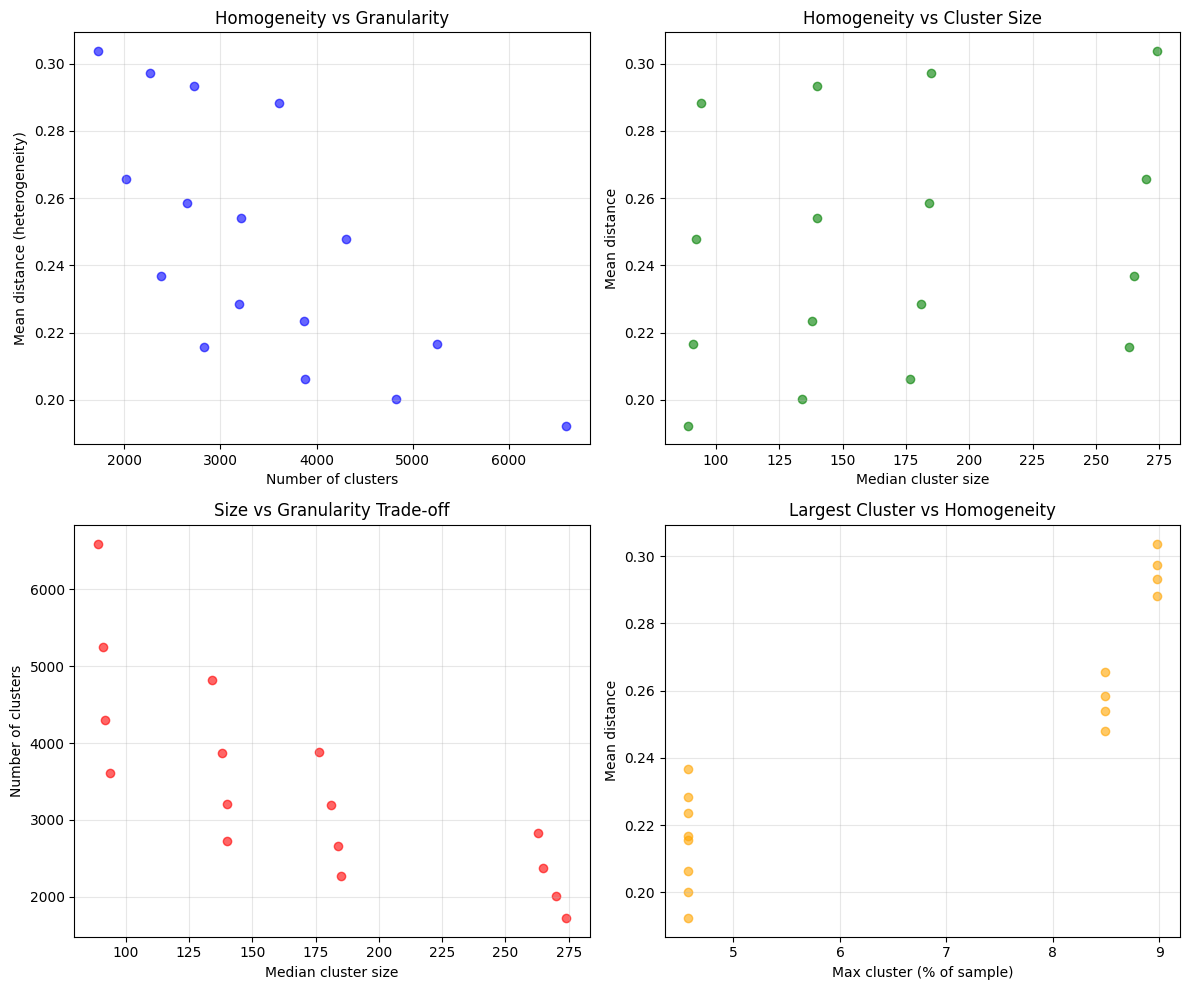

In [6]:
print("\n" + "="*80)
print("TRADE-OFF ANALYSIS")
print("="*80)
print("\nAll configurations tested:")
print(results_df[['min_improvement', 'min_size', 'mean_dist', 'n_clusters', 'median_size', 'max_cluster_pct']].to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(results_df['n_clusters'], results_df['mean_dist'], c='blue', alpha=0.6)
axes[0, 0].set_xlabel('Number of clusters')
axes[0, 0].set_ylabel('Mean distance (heterogeneity)')
axes[0, 0].set_title('Homogeneity vs Granularity')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(results_df['median_size'], results_df['mean_dist'], c='green', alpha=0.6)
axes[0, 1].set_xlabel('Median cluster size')
axes[0, 1].set_ylabel('Mean distance')
axes[0, 1].set_title('Homogeneity vs Cluster Size')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(results_df['median_size'], results_df['n_clusters'], c='red', alpha=0.6)
axes[1, 0].set_xlabel('Median cluster size')
axes[1, 0].set_ylabel('Number of clusters')
axes[1, 0].set_title('Size vs Granularity Trade-off')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(results_df['max_cluster_pct'], results_df['mean_dist'], c='orange', alpha=0.6)
axes[1, 1].set_xlabel('Max cluster (% of sample)')
axes[1, 1].set_ylabel('Mean distance')
axes[1, 1].set_title('Largest Cluster vs Homogeneity')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('parameter_tradeoff.png', dpi=150)
print("\nSaved trade-off visualization: parameter_tradeoff.png")

print("\n" + "="*80)
print("SELECTION CRITERIA")
print("="*80)
print("Filtering configurations:")
print("  - Median size >= 100 (statistical power for uplift analysis)")
print("  - Max cluster < 10% of sample (avoid mega-clusters)")

viable = results_df[
    (results_df['median_size'] >= 100) &
    (results_df['max_cluster_pct'] < 10)
]

print(f"\nViable configurations: {len(viable)}/{len(results_df)}")
if len(viable) > 0:
    print(viable[['min_improvement', 'min_size', 'mean_dist', 'n_clusters', 'median_size']].to_string(index=False))

    best_idx = viable['mean_dist'].idxmin()
    best_config = viable.loc[best_idx]

    print(f"\nSelected configuration (lowest mean_dist among viable):")
    print(f"  min_improvement: {best_config['min_improvement']}")
    print(f"  min_size: {best_config['min_size']}")
    print(f"  mean_dist: {best_config['mean_dist']:.4f}")
    print(f"  n_clusters: {int(best_config['n_clusters'])}")
    print(f"  median_size: {best_config['median_size']:.0f}")
else:
    print("\nNo configurations meet both criteria. Relaxing constraints...")
    viable = results_df[results_df['median_size'] >= 100]
    if len(viable) > 0:
        best_idx = viable['mean_dist'].idxmin()
        best_config = viable.loc[best_idx]
        print(f"Selected: min_improvement={best_config['min_improvement']}, min_size={best_config['min_size']}")
    else:
        best_idx = results_df['mean_dist'].idxmin()
        best_config = results_df.loc[best_idx]
        print(f"Using best mean_dist: min_improvement={best_config['min_improvement']}, min_size={best_config['min_size']}")

## APPLY TO FULL DATASET

In [7]:
print("\n" + "="*80)
print("APPLYING TO FULL DATASET")
print("="*80)
print(f"Using parameters: min_improvement={best_config['min_improvement']}, min_size={best_config['min_size']}")

final_clusterer = HierarchicalWeightedKMeans(
    min_improvement=best_config['min_improvement'],
    min_size=best_config['min_size'],
    variance_threshold=0.02,
    max_depth=50,
    force_split_threshold=500000
)

final_labels, final_mean_dist = final_clusterer.fit_predict(df_full)
final_stats = calculate_cluster_stats(final_labels)

print(f"\nFinal results:")
print(f"  Mean distance: {final_mean_dist:.4f}")
print(f"  Number of clusters: {final_stats['n_clusters']}")
print(f"  Median cluster size: {final_stats['median_size']:.0f}")
print(f"  Largest cluster: {final_stats['max_size']:,} ({final_stats['max_size']/len(df_full)*100:.1f}% of dataset)")

df_full['cluster'] = final_labels


APPLYING TO FULL DATASET
Using parameters: min_improvement=0.04, min_size=75.0

Final results:
  Mean distance: 0.1694
  Number of clusters: 11538
  Median cluster size: 136
  Largest cluster: 465,116 (3.3% of dataset)


## SAVE RESULTS

In [11]:
print("\nSaving results...")
df_full.to_csv('clustered_data.csv.gz', index=False, compression='gzip')
results_df.to_csv('parameter_search_results.csv', index=False)

summary = {
    'selected_parameters': {
        'min_improvement': float(best_config['min_improvement']),
        'min_size': int(best_config['min_size']),
        'variance_threshold': 0.02,
        'max_depth': 50,
        'force_split_threshold': 500000
    },
    'sample_results': {
        'sample_size': len(df_sample),
        'mean_dist': float(best_config['mean_dist']),
        'n_clusters': int(best_config['n_clusters']),
        'median_size': float(best_config['median_size'])
    },
    'full_dataset_results': {
        'total_observations': len(df_full),
        'mean_dist': float(final_mean_dist),
        'n_clusters': int(final_stats['n_clusters']),
        'median_size': float(final_stats['median_size']),
        'mean_size': float(final_stats['mean_size']),
        'min_size': int(final_stats['min_size']),
        'max_size': int(final_stats['max_size'])
    },
    'selected_features': final_clusterer.selected_features,
    'all_configurations': results_df.to_dict('records')
}

with open('clustering_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Done. Files saved:")
print("  - clustered_data.csv.gz")
print("  - parameter_search_results.csv")
print("  - clustering_summary.json")
print("  - parameter_tradeoff.png")


Saving results...
Done. Files saved:
  - clustered_data.csv.gz
  - parameter_search_results.csv
  - clustering_summary.json
  - parameter_tradeoff.png
